# AI-Generated Image Detection using CNN

This notebook implements a Convolutional Neural Network (CNN) to classify images as **Real** or **AI-Generated (Fake)**. 

## Overview

1. **Model Architecture**: A custom CNN with 3 convolutional blocks for feature extraction
2. **Data Pipeline**: Loading, preprocessing, and augmentation of images
3. **Training Loop**: Complete training with validation and model checkpointing
4. **Evaluation**: Performance metrics including Accuracy, Precision, Recall, and F1-Score

## Dataset Structure

The dataset should be organized in the following folder structure:
```
archive/
├── FAKE/    # AI-generated images
└── REAL/    # Real photographs
```

## 1. Import Libraries

Import all necessary libraries for deep learning, data handling, and evaluation metrics.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, roc_curve, auc, 
                             classification_report)
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## 2. Configuration

Define hyperparameters and settings for the model training.

In [2]:
# Configuration
DATA_DIR = 'archive'
BATCH_SIZE = 512
IMG_SIZE = 128
LEARNING_RATE = 0.001
NUM_EPOCHS = 10

# Specific device selection: Use GPU (cuda) if available for faster training, otherwise fallback to CPU.
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

Using device: cuda


## 3. Model Architecture

The CNN architecture consists of:
- **3 Convolutional Blocks**: Each block contains Conv2D → BatchNorm → ReLU → MaxPool
- **Fully Connected Layers**: For classification after feature extraction
- **Dropout**: To prevent overfitting

### Architecture Details

| Layer | Input Size | Output Size | Description |
|-------|------------|-------------|-------------|
| Conv1 | 128×128×3 | 128×128×32 | Extract low-level features |
| Pool1 | 128×128×32 | 64×64×32 | Reduce spatial dimensions |
| Conv2 | 64×64×32 | 64×64×64 | Extract mid-level features |
| Pool2 | 64×64×64 | 32×32×64 | Reduce spatial dimensions |
| Conv3 | 32×32×64 | 32×32×128 | Extract high-level features |
| Pool3 | 32×32×128 | 16×16×128 | Reduce spatial dimensions |
| FC1 | 32768 | 512 | Classification layer |
| FC2 | 512 | 1 | Output (logit) |

In [3]:
class AIImageDetectorCNN(nn.Module):
    """
    A Convolutional Neural Network (CNN) for binary image classification (Real vs Fake).
    """
    def __init__(self):
        super(AIImageDetectorCNN, self).__init__()
        
        # Convolutional Layers (Feature Extraction)
        # We assume input images are resized to 128x128 pixels with 3 color channels (RGB).
        # Input Shape: [Batch_Size, 3, 128, 128]
        
        # Layer 1: 
        # Conv2d: Extracts low-level features (edges, colors).
        # out_channels=32: Creates 32 different feature maps.
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        # BatchNorm2d: Normalizes the output of the convolution. 
        # Helps training stability and speed by keeping activation distributions consistent.
        self.bn1 = nn.BatchNorm2d(32)
        
        # Layer 2:
        # Increases depth to 64 channels to capture more complex textures/patterns.
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        # Layer 3:
        # Increases depth to 128 channels for high-level feature abstraction.
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        # Pooling Layer: 
        # MaxPool2d reduces spatial dimensions (height/width) by half (stride=2).
        # This reduces computation and makes the model translation invariant (robust to position shifts).
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Dropout: 
        # Randomly zeros out 50% of neurons during training.
        # Prevents overfitting by forcing the network to learn redundant representations.
        self.dropout = nn.Dropout(0.5)
        
        # Fully Connected Layers (Classification)
        # Calculate Flattened Input Size:
        # Original Image: 128x128
        # After Pool 1: 64x64
        # After Pool 2: 32x32
        # After Pool 3: 16x16
        # Final Tensor Shape before flattening: [Batch_Size, 128 (channels), 16, 16]
        # Flattened Vector Size = 128 * 16 * 16 = 32768
        self.fc1 = nn.Linear(128 * 16 * 16, 512)
        
        # Output Layer: 
        # Maps the 512 features to a single value (logit).
        # A positive value suggests one class (e.g., Real), negative suggests the other (Fake).
        self.fc2 = nn.Linear(512, 1) 

    def forward(self, x):
        """
        Defines the forward pass (data flow) of the network.
        Args:
            x: Input batch of images.
        Returns:
            x: Unnormalized output scores (logits).
        """
        
        # Block 1: Conv -> BN -> ReLU -> Pool
        # ReLU (Rectified Linear Unit) introduces non-linearity, allowing the model to learn complex functions.
        # without ReLU, the model would just be a linear regression.
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        
        # Block 2
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        
        # Block 3
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        
        # Flattening:
        # Reshapes the 3D feature maps (Channels, Height, Width) into a 1D vector
        # so it can be fed into the Fully Connected (Dense) layers.
        # x.size(0) preserves the batch size. -1 infers the remaining dimension size.
        x = x.view(x.size(0), -1)
        
        # Classification Head:
        # FC1 -> ReLU -> Dropout
        x = self.dropout(F.relu(self.fc1(x)))
        
        # Final Output (Logit)
        # We do NOT apply Sigmoid here because we use BCEWithLogitsLoss during training,
        # which applies Sigmoid internally for better numerical stability.
        x = self.fc2(x)
        
        return x

## 4. Data Loading and Preprocessing

The data pipeline includes:
- **Resize**: All images are resized to 128×128 pixels
- **ToTensor**: Converts PIL images (0-255) to PyTorch tensors (0-1)
- **Normalize**: Standardizes pixel values using ImageNet statistics for better convergence

The dataset is split into **80% training** and **20% validation**.

In [4]:
def get_data_loaders(data_dir, batch_size, img_size):
    """
    Prepares the training and validation data loaders.
    
    Args:
        data_dir (str): Path to the dataset directory.
        batch_size (int): Number of images per batch.
        img_size (int): Target size to resize images.
        
    Returns:
        train_loader: DataLoader for training data.
        val_loader: DataLoader for validation data.
        class_to_idx: Dictionary mapping class names to indices.
    """
    # Data augmentation and normalization for training
    # - Resize: Ensures all images are the same size for the neural network input.
    # - ToTensor: Converts PIL images (0-255) to PyTorch tensors (0-1).
    # - Normalize: Standardizes pixel values to resemble ImageNet statistics (mean ~0, std ~1).
    #   This helps the model converge (learn) faster and reach a stable solution.
    #   Values (0.485, ...) are standard constants for pre-trained models/general natural images gathered from the internet.
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Load dataset from folder structure (folder name = class label)
    try:
        full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
    except FileNotFoundError:
        print(f"Error: Data directory '{data_dir}' not found.")
        return None, None, None

    # Split into train and validation (80/20)
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    print(f"Dataset loaded. Classes: {full_dataset.classes}")
    print(f"Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")

    # DataLoader handles batching, shuffling, and parallel data loading (num_workers).
    # Shuffle=True for training prevents the model from learning order-based patterns.
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

    return train_loader, val_loader, full_dataset.class_to_idx

## 5. Evaluation Function

This function calculates key classification metrics:
- **Accuracy**: Overall correct predictions
- **Precision**: True positives / (True positives + False positives)
- **Recall**: True positives / (True positives + False negatives)
- **F1-Score**: Mean of precision and recall

In [5]:
def evaluate_model(model, loader, device, return_predictions=False):
    """
    Evaluates the model's performance on a given dataset (validation/test).
    
    Args:
        model: The neural network model.
        loader: DataLoader for the dataset.
        device: 'cuda' or 'cpu'.
        return_predictions: If True, also return raw probabilities and labels for ROC curve.
    
    Returns:
        acc, prec, rec, f1: Performance metrics.
        (Optional) all_probs, all_labels: Raw predictions for further analysis.
    """
    # Set model to evaluation mode.
    # Disables Dropout and switches BatchNorm to use running statistics.
    model.eval()
    
    all_preds = []
    all_labels = []
    all_probs = []
    
    # torch.no_grad() disables gradient calculation.
    # We don't need gradients for evaluation, and this saves memory and computation.
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()
            
            # Move results back to CPU and convert to numpy for scikit-learn metrics
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            
    # Calculate metrics using scikit-learn
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, zero_division=0)
    rec = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    
    if return_predictions:
        return acc, prec, rec, f1, np.array(all_probs).flatten(), np.array(all_labels)
    
    return acc, prec, rec, f1

## 6. Training Function

The training loop implements:
- **Forward pass**: Compute predictions
- **Loss calculation**: Using Binary Cross-Entropy with Logits
- **Backward pass**: Compute gradients via backpropagation
- **Optimizer step**: Update model weights
- **Model checkpointing**: Save the best model based on validation accuracy

In [6]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    """
    Executes the training loop.
    
    Args:
        model: The neural network model.
        train_loader: DataLoader for training data.
        val_loader: DataLoader for validation data.
        criterion: Loss function (BCEWithLogitsLoss).
        optimizer: Optimization algorithm (Adam).
        num_epochs: Number of times to iterate over the entire dataset.
        device: 'cuda' or 'cpu'.
    
    Returns:
        history: Dictionary containing training metrics per epoch.
    """
    best_acc = 0.0
    
    # Track metrics for visualization
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_acc': [],
        'val_precision': [],
        'val_recall': [],
        'val_f1': []
    }
    
    print(f"Starting training on {device}...")
    
    for epoch in range(num_epochs):
        # Set model to training mode. 
        # This enables layers like Dropout and BatchNorm that behave differently during training vs inference.
        model.train()
        
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        # tqdm creates a visual progress bar for the epoch loop (wraps around the DataLoader)
        loop = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        
        for inputs, labels in loop:
            # Move data to the configured device (GPU/CPU) for computation
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients.
            # PyTorch accumulates gradients by default. We must clear them before the backward pass
            # of this batch, otherwise gradients from previous batches would mix in.
            optimizer.zero_grad()
            
            # Forward Pass: Compute predicted outputs by passing inputs to the model
            outputs = model(inputs)
            
            # Prepare labels for Loss Calculation
            # BCEWithLogitsLoss expects labels to be Float tensors.
            # .unsqueeze(1) reshapes labels from [batch_size] to [batch_size, 1] to match the shape of the model output.
            labels = labels.float().unsqueeze(1) 
            
            # Calculate Loss: Determine how wrong the model's predictions are compared to actual labels
            loss = criterion(outputs, labels)
            
            # Backward Pass (Backpropagation):
            # Calculates the gradient of the loss with respect to model parameters.
            # It figures out "direction" and "magnitude" to adjust weights to reduce error.
            loss.backward()
            
            # Optimizer Step:
            # Updates the model's weights based on the computed gradients.
            optimizer.step()
            
            # Statistics & Metrics Tracking:
            
            # Add current batch loss to running total (loss.item() extracts the scalar value)
            running_loss += loss.item()
            
            # Convert logits (raw output) to probabilities using Sigmoid (0 to 1 range)
            probs = torch.sigmoid(outputs)
            
            # Threshold probabilities to binary predictions (0 or 1)
            preds = (probs > 0.5).float()
            
            # Count correct predictions
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)
            
            # Update progress bar with current batch loss
            loop.set_postfix(loss=loss.item())

        # Calculate average loss and accuracy for the epoch
        train_acc = correct_train / total_train
        avg_loss = running_loss / len(train_loader)
        
        # Validation phase: Evaluate model on unseen data
        val_acc, val_precision, val_recall, val_f1 = evaluate_model(model, val_loader, device)
        
        # Store metrics in history
        history['train_loss'].append(avg_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['val_precision'].append(val_precision)
        history['val_recall'].append(val_recall)
        history['val_f1'].append(val_f1)
        
        print(f"Epoch {epoch+1}/{num_epochs} -> "
              f"Loss: {avg_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}")
        
        # Save the best model based on validation accuracy.
        # This ensures we keep the version of the model that generalized best, 
        # not necessarily the one from the very last epoch (which might be overfitting).
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
            print("Saved best model.")

    print("Training complete.")
    return history

## 7. Load and Prepare Data

Load the dataset and create data loaders for training and validation.

In [7]:
# Load data
train_loader, val_loader, class_mapping = get_data_loaders(DATA_DIR, BATCH_SIZE, IMG_SIZE)

# Display class mapping
print(f"Class Mapping: {class_mapping}")  # {'FAKE': 0, 'REAL': 1}

Dataset loaded. Classes: ['FAKE', 'REAL']
Training samples: 31963, Validation samples: 7991
Class Mapping: {'FAKE': 0, 'REAL': 1}


## 8. Initialize Model, Loss Function, and Optimizer

- **Model**: Custom CNN architecture
- **Loss Function**: `BCEWithLogitsLoss` - combines Sigmoid + Binary Cross-Entropy for numerical stability
- **Optimizer**: `Adam` - Adaptive Moment Estimation, generally converges faster than SGD (Stochastic Gradient Descent)

In [8]:
# Initialize the model and move to device
model = AIImageDetectorCNN().to(DEVICE)

# BCEWithLogitsLoss combines Sigmoid layer + BCELoss in one class.
# This is numerically more stable than using a plain Sigmoid followed by BCELoss.
criterion = nn.BCEWithLogitsLoss()

# Adam optimizer: Adaptive Moment Estimation.
# Generally performs better and converges faster than SGD for many deep learning tasks.
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Display model summary
print(f"Model moved to: {DEVICE}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

Model moved to: cuda
Total parameters: 16,871,937


## 9. Train the Model

Run the training loop. The best model (based on validation accuracy) will be automatically saved to `best_model.pth`.

In [9]:
# Train the model and capture training history
history = train_model(model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS, DEVICE)

Starting training on cuda...


Epoch 1/10 [Train]: 100%|██████████| 63/63 [02:51<00:00,  2.72s/it, loss=0.469]


Epoch 1/10 -> Loss: 1.8417, Train Acc: 0.7083, Val Acc: 0.7930, Val F1: 0.7775
Saved best model.


Epoch 2/10 [Train]: 100%|██████████| 63/63 [02:34<00:00,  2.44s/it, loss=0.444]


Epoch 2/10 -> Loss: 0.4194, Train Acc: 0.8067, Val Acc: 0.8326, Val F1: 0.8308
Saved best model.


Epoch 3/10 [Train]: 100%|██████████| 63/63 [02:43<00:00,  2.59s/it, loss=0.238]


Epoch 3/10 -> Loss: 0.3733, Train Acc: 0.8322, Val Acc: 0.8557, Val F1: 0.8556
Saved best model.


Epoch 4/10 [Train]: 100%|██████████| 63/63 [02:47<00:00,  2.66s/it, loss=0.324]


Epoch 4/10 -> Loss: 0.3377, Train Acc: 0.8552, Val Acc: 0.8636, Val F1: 0.8620
Saved best model.


Epoch 5/10 [Train]: 100%|██████████| 63/63 [02:49<00:00,  2.69s/it, loss=0.302]


Epoch 5/10 -> Loss: 0.3095, Train Acc: 0.8681, Val Acc: 0.8749, Val F1: 0.8680
Saved best model.


Epoch 6/10 [Train]: 100%|██████████| 63/63 [02:53<00:00,  2.76s/it, loss=0.196]


Epoch 6/10 -> Loss: 0.2843, Train Acc: 0.8827, Val Acc: 0.8801, Val F1: 0.8789
Saved best model.


Epoch 7/10 [Train]: 100%|██████████| 63/63 [02:51<00:00,  2.72s/it, loss=0.224]


Epoch 7/10 -> Loss: 0.2730, Train Acc: 0.8879, Val Acc: 0.8978, Val F1: 0.8993
Saved best model.


Epoch 8/10 [Train]: 100%|██████████| 63/63 [02:49<00:00,  2.69s/it, loss=0.281]


Epoch 8/10 -> Loss: 0.2560, Train Acc: 0.8958, Val Acc: 0.9079, Val F1: 0.9111
Saved best model.


Epoch 9/10 [Train]: 100%|██████████| 63/63 [02:47<00:00,  2.66s/it, loss=0.199]


Epoch 9/10 -> Loss: 0.2345, Train Acc: 0.9084, Val Acc: 0.8844, Val F1: 0.8758


Epoch 10/10 [Train]: 100%|██████████| 63/63 [02:53<00:00,  2.75s/it, loss=0.226]


Epoch 10/10 -> Loss: 0.2147, Train Acc: 0.9162, Val Acc: 0.8701, Val F1: 0.8584
Training complete.


## 10. Training History Visualization

Visualize the training progress across epochs to understand model learning behavior and detect potential overfitting.

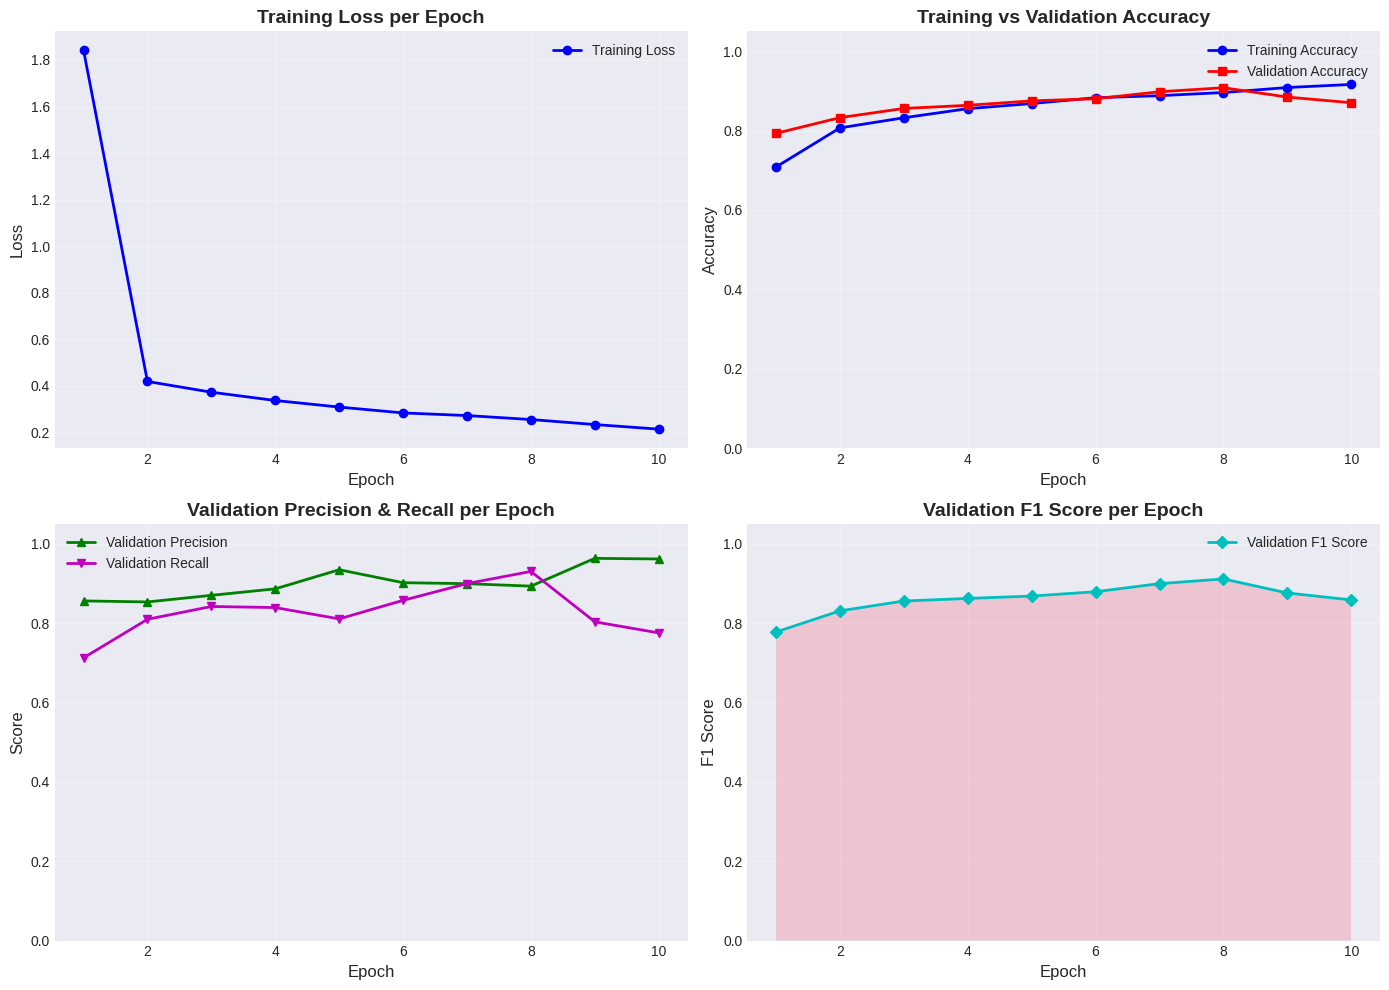

TRAINING SUMMARY
Best Validation Accuracy: 0.9079 (Epoch 8)
Best Validation F1 Score: 0.9111 (Epoch 8)
Final Training Loss: 0.2147


In [10]:
def plot_training_history(history):
    """Plot training metrics over epochs."""
    epochs = range(1, len(history['train_loss']) + 1)
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot 1: Training Loss
    ax1 = axes[0, 0]
    ax1.plot(epochs, history['train_loss'], 'b-o', linewidth=2, markersize=6, label='Training Loss')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title('Training Loss per Epoch', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Accuracy (Train vs Validation)
    ax2 = axes[0, 1]
    ax2.plot(epochs, history['train_acc'], 'b-o', linewidth=2, markersize=6, label='Training Accuracy')
    ax2.plot(epochs, history['val_acc'], 'r-s', linewidth=2, markersize=6, label='Validation Accuracy')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy', fontsize=12)
    ax2.set_title('Training vs Validation Accuracy', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim([0, 1.05])
    
    # Plot 3: Precision and Recall
    ax3 = axes[1, 0]
    ax3.plot(epochs, history['val_precision'], 'g-^', linewidth=2, markersize=6, label='Validation Precision')
    ax3.plot(epochs, history['val_recall'], 'm-v', linewidth=2, markersize=6, label='Validation Recall')
    ax3.set_xlabel('Epoch', fontsize=12)
    ax3.set_ylabel('Score', fontsize=12)
    ax3.set_title('Validation Precision & Recall per Epoch', fontsize=14, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.set_ylim([0, 1.05])
    
    # Plot 4: F1 Score
    ax4 = axes[1, 1]
    ax4.plot(epochs, history['val_f1'], 'c-D', linewidth=2, markersize=6, label='Validation F1 Score')
    ax4.fill_between(epochs, history['val_f1'], alpha=0.3)
    ax4.set_xlabel('Epoch', fontsize=12)
    ax4.set_ylabel('F1 Score', fontsize=12)
    ax4.set_title('Validation F1 Score per Epoch', fontsize=14, fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    ax4.set_ylim([0, 1.05])
    
    plt.tight_layout()
    plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Print summary statistics
    print("TRAINING SUMMARY")
    print(f"Best Validation Accuracy: {max(history['val_acc']):.4f} (Epoch {np.argmax(history['val_acc'])+1})")
    print(f"Best Validation F1 Score: {max(history['val_f1']):.4f} (Epoch {np.argmax(history['val_f1'])+1})")
    print(f"Final Training Loss: {history['train_loss'][-1]:.4f}")

# Plot the training history
plot_training_history(history)

## 11. Final Model Evaluation

Load the best saved model and perform comprehensive evaluation including:
- **Confusion Matrix**: Visualize true/false positives and negatives
- **ROC Curve & AUC**: Receiver Operating Characteristic curve and Area Under Curve
- **Classification Report**: Detailed precision, recall, and F1-score per class

In [11]:
# Load the best weights saved during training (not necessarily the last epoch's weights)
model.load_state_dict(torch.load('best_model.pth'))

# Evaluate on validation set with predictions for ROC curve
print("Final Evaluation on Validation Set")
acc, prec, rec, f1, all_probs, all_labels = evaluate_model(model, val_loader, DEVICE, return_predictions=True)

print(f"\nAccuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")

Final Evaluation on Validation Set

Accuracy:  0.9079
Precision: 0.8930
Recall:    0.9300
F1 Score:  0.9111


### 11.1 Confusion Matrix

The confusion matrix shows the breakdown of predictions:
- **True Negatives (TN)**: Correctly predicted FAKE
- **False Positives (FP)**: FAKE predicted as REAL
- **False Negatives (FN)**: REAL predicted as FAKE
- **True Positives (TP)**: Correctly predicted REAL

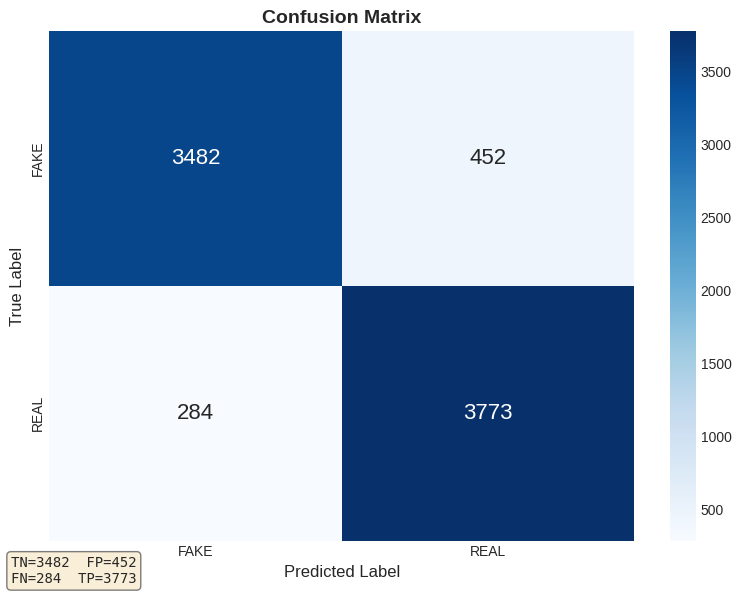


Confusion Matrix Breakdown:
  True Negatives (FAKE correctly identified):  3482
  False Positives (FAKE predicted as REAL):    452
  False Negatives (REAL predicted as FAKE):    284
  True Positives (REAL correctly identified):  3773


In [12]:
# Generate predictions for confusion matrix
all_preds = (all_probs > 0.5).astype(int)

# Create confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['FAKE', 'REAL'], 
            yticklabels=['FAKE', 'REAL'],
            annot_kws={'size': 16},
            ax=ax)
ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('True Label', fontsize=12)
ax.set_title('Confusion Matrix', fontsize=14, fontweight='bold')

# Add text annotations for metrics
tn, fp, fn, tp = cm.ravel()
text = f'TN={tn}  FP={fp}\nFN={fn}  TP={tp}'
plt.figtext(0.02, 0.02, text, fontsize=10, family='monospace',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# Print detailed breakdown
print(f"\nConfusion Matrix Breakdown:")
print(f"  True Negatives (FAKE correctly identified):  {tn}")
print(f"  False Positives (FAKE predicted as REAL):    {fp}")
print(f"  False Negatives (REAL predicted as FAKE):    {fn}")
print(f"  True Positives (REAL correctly identified):  {tp}")

### 11.2 ROC Curve & AUC Score

The ROC (Receiver Operating Characteristic) curve plots the True Positive Rate against the False Positive Rate at various threshold settings. The AUC (Area Under the Curve) provides a single metric to evaluate the model's discriminative ability:
- **AUC = 1.0**: Perfect classifier
- **AUC = 0.5**: Random classifier (no discrimination)
- **AUC > 0.9**: Excellent discrimination

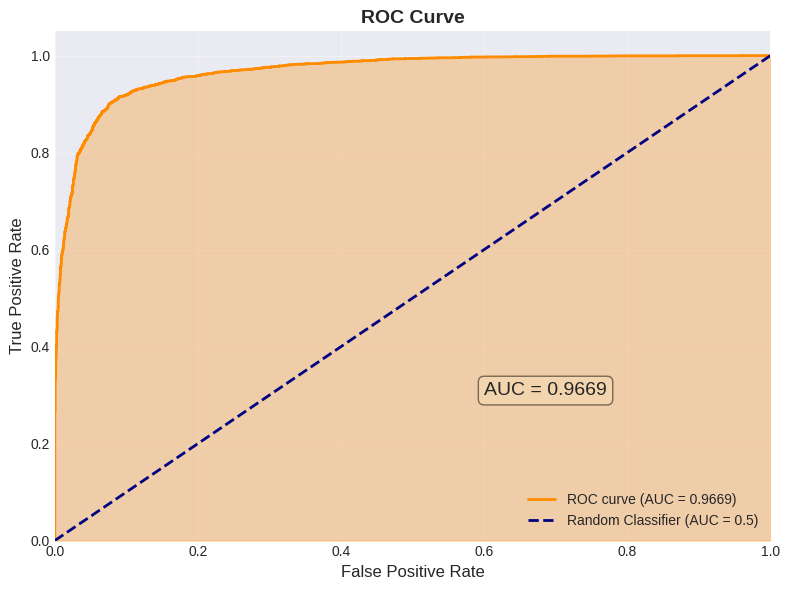


AUC Score: 0.9669


In [13]:
# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier (AUC = 0.5)')

# Fill area under curve
ax.fill_between(fpr, tpr, alpha=0.3, color='darkorange')

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curve', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=10)
ax.grid(True, alpha=0.3)

# Add AUC annotation
ax.annotate(f'AUC = {roc_auc:.4f}', xy=(0.6, 0.3), fontsize=14, 
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('roc_curve.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nAUC Score: {roc_auc:.4f}")

### 11.4 Classification Report & Final Metrics Summary

A comprehensive summary of all evaluation metrics for both classes.

CLASSIFICATION REPORT
              precision     recall   f1-score    support

        FAKE       0.92       0.89       0.90       3934
        REAL       0.89       0.93       0.91       4057

    accuracy                             0.91       7991


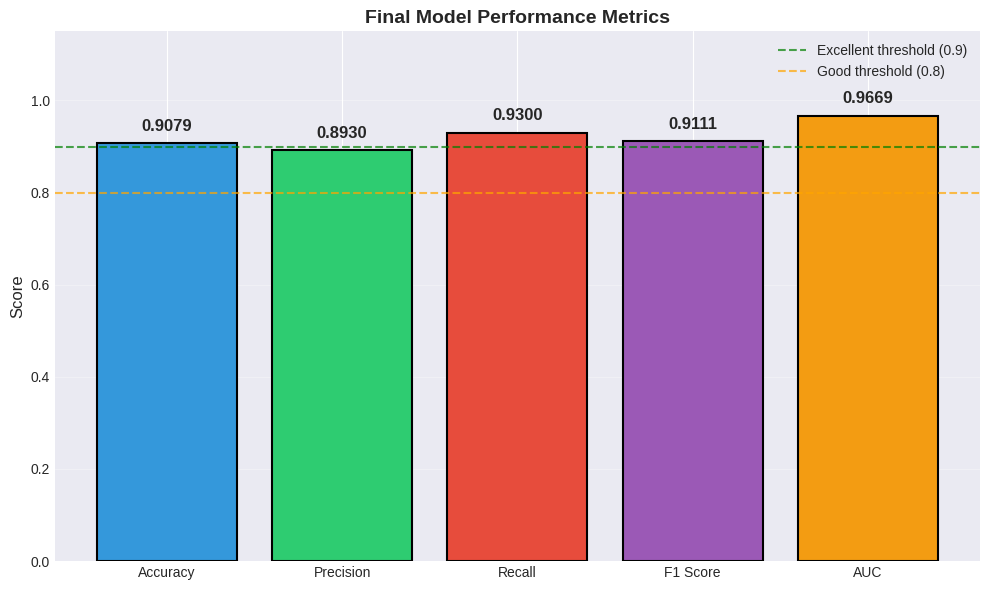

FINAL MODEL SUMMARY
  Accuracy:           0.9079
  Precision:          0.8930
  Recall:             0.9300
  F1 Score:           0.9111
  AUC Score:          0.9669

Model saved to: best_model.pth
Visualizations saved to: training_history.png, confusion_matrix.png,
                         roc_curve.png, final_metrics.png


In [14]:
# Print detailed classification report 
print("CLASSIFICATION REPORT")

# Get classification report as dictionary
report_dict = classification_report(all_labels, all_preds, target_names=['FAKE', 'REAL'], output_dict=True)

# Print header
print(f"{'':>12} {'precision':>10} {'recall':>10} {'f1-score':>10} {'support':>10}")
print()

# Print class-level metrics (FAKE and REAL)
for class_name in ['FAKE', 'REAL']:
    metrics = report_dict[class_name]
    print(f"{class_name:>12} {metrics['precision']:>10.2f} {metrics['recall']:>10.2f} {metrics['f1-score']:>10.2f} {metrics['support']:>10.0f}")

print()
print(f"{'accuracy':>12} {'':>10} {'':>10} {report_dict['accuracy']:>10.2f} {report_dict['macro avg']['support']:>10.0f}")

# Create final summary visualization
fig, ax = plt.subplots(figsize=(10, 6))

# Metrics for bar chart
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']
metrics_values = [acc, prec, rec, f1, roc_auc]
colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6', '#f39c12']

bars = ax.bar(metrics_names, metrics_values, color=colors, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bar, val in zip(bars, metrics_values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
            f'{val:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylim([0, 1.15])
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Final Model Performance Metrics', fontsize=14, fontweight='bold')
ax.axhline(y=0.9, color='green', linestyle='--', alpha=0.7, label='Excellent threshold (0.9)')
ax.axhline(y=0.8, color='orange', linestyle='--', alpha=0.7, label='Good threshold (0.8)')
ax.legend(loc='upper right')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('final_metrics.png', dpi=150, bbox_inches='tight')
plt.show()

# Print final summary
print("FINAL MODEL SUMMARY")
print(f"  Accuracy:           {acc:.4f}")
print(f"  Precision:          {prec:.4f}")
print(f"  Recall:             {rec:.4f}")
print(f"  F1 Score:           {f1:.4f}")
print(f"  AUC Score:          {roc_auc:.4f}")
print(f"\nModel saved to: best_model.pth")
print("Visualizations saved to: training_history.png, confusion_matrix.png,")
print("                         roc_curve.png, final_metrics.png")